In [1]:
import base64
import requests
from openai import OpenAI
import time
import pandas as pd
import json
from tqdm import tqdm
import glob
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow

%matplotlib inline

In [2]:
import os
os.environ["OPENAI_API_KEY"] = 'aaa'

### Test

In [19]:
client = OpenAI()

stream = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": "Say this is a test"}],
    stream=True,
)
for chunk in stream:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="")

Sure! "This is a test." Feel free to ask anything else or let me know how I can assist you further.

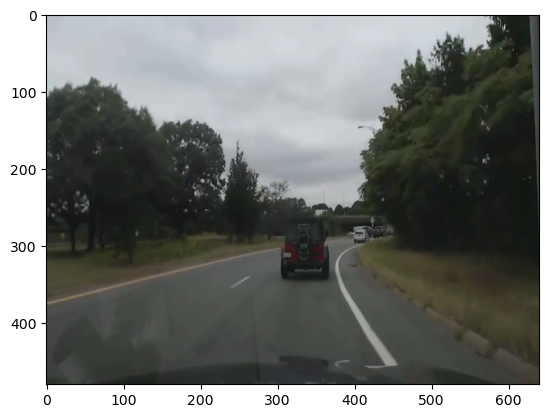

In [34]:
image_path = r"../../0_data/1_intermediate_OneFormer/extracted_frames/001_0.png"

image = Image.open(image_path)
image = image.resize((640, 480))
imshow(np.asarray(image))

In [35]:
# OpenAI API Key
api_key = os.environ["OPENAI_API_KEY"]

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "../../0_data/1_intermediate_OneFormer/extracted_frames/001_0.png"

# Getting the base64 string
base64_image = encode_image(image_path)

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

prompt = f"""This is the front-camera view image that you, as a driver, can see. I'm interested in the complexity and demanding level of the roadway scene for drivers, so you are asked to answer the following questions. Please give your answers in JSON format, including the following fields: \
From this image, can you tell me how demanding this environment is for you to navigate and drive on? (0 - 10 scale),
What is the weather like in the image? Please choose one of the following: clear, cloudy, rainy, snowy, foggy, night.
What is the road condition like in the image? Please choose one of the following: dry, wet, icy.
What is the traffic condition like in the image? Please choose one of the following: light, moderate, heavy.
What is the visibility like in the image? Please choose one of the following: clear, low visibility.
What is the time of day in the image? Please choose one of the following: day, night, dusk/dawn.
What is the road layout like in the image? Please choose one of the following: straight, curved, slight curve.
What is the road type like in the image? Please choose one of the following: highway, city street, rural road, residential area.
What is the speed limit in the image? Please give your best conjecture (e.g., 30 km/h, 50 km/h, 80 km/h, etc.),
What is the road width like in the image? Please choose one of the following: narrow, medium, wide.
"""

payload = {
  "model": "gpt-4o-2024-08-06",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())

{'id': 'chatcmpl-9vZCc92Qn8kcH76qf2FyjsFChFAjB', 'object': 'chat.completion', 'created': 1723507042, 'model': 'gpt-4o-2024-08-06', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '```json\n{\n  "demanding_level": 4,\n  "weather": "cloudy",\n  "road_condition": "dry",\n  "traffic_condition": "moderate",\n  "visibility": "clear",\n  "time_of_day": "day",\n  "road_layout": "slight curve",\n  "road_type": "city street",\n  "speed_limit": "50 km/h",\n  "road_width": "medium"\n}\n```', 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 1428, 'completion_tokens': 94, 'total_tokens': 1522}, 'system_fingerprint': 'fp_845eaabc1f'}


### Batch processing
https://platform.openai.com/docs/guides/batch/getting-started

In [4]:
prompt = f"""This is the front-camera view image that you, as a driver, can see. I'm interested in the complexity and demanding level of the roadway scene for drivers, so you are asked to answer the following questions. Please give your answers in JSON format, including the following fields: \
From this image, can you tell me how demanding this environment is for you to navigate and drive on? (0 - 10 scale),
What is the weather like in the image? clear, cloudy, rainy, snowy, foggy, night.
What is the road condition like in the image? dry, wet, icy.
What is the traffic condition like in the image? light, moderate, heavy.
What is the visibility like in the image? clear, low visibility.
What is the time of day in the image? day, night, dusk/dawn.
What is the road layout like in the image? straight, curved, slight curve.
What is the road type like in the image? highway, city street, rural road, residential area.
What is the speed limit in the image? (e.g., 30 km/h, 50 km/h, 80 km/h, etc.),
What is the road width like in the image? narrow, medium, wide.
"""

#### Preparation

In [6]:
# prepare the batch file in json
batch = []
image_path = glob.glob("../../0_data/1_intermediate_OneFormer/extracted_frames/*_0.png")
image_path.sort()

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
  
batch_index = 0
for image in image_path:
    image_id = image.split("/")[-1].split(".")[0].split("_")[0]
    
    base64_image = encode_image(image)
    payload = {
      "model": "gpt-4o-mini",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
      ],
      "max_tokens": 300
    }

    batch.append({"custom_id": image.split("/")[-1].split(".")[0], "method": "POST",
                  "url": "/v1/chat/completions", 
                  "body": payload})
    
    # save the batch file every 100 images
    if int(image_id) % 100 == 0:
        with open(f"batch_{batch_index}.jsonl", "w") as f:
            for line in batch:
              f.write(json.dumps(line) + "\n")
        batch = []
        batch_index += 1

#### Batch 0

In [27]:
# upload the batch file 0
client = OpenAI()

batch_input_file = client.files.create(
  file=open("batch_0.jsonl", "rb"),
  purpose="batch"
)

# create the batch job
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "roadway understanding, 100 images",
    }
)

Batch(id='batch_zzNZcHjL0yGWI1rw6byolQhM', completion_window='24h', created_at=1723503084, endpoint='/v1/chat/completions', input_file_id='file-HQCJYox61Uuv0EeRNyUUuquA', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1723589484, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'roadway understanding, 100 images'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [4]:
# check the status of the task
status = client.batches.retrieve("batch_9ikWlMXG9gcscy1L0JHOl4ol")
print(status.status)
print(status.output_file_id)
print(status.request_counts)

completed
file-1Qfaxe846hAv4y2AZDF7xIO2
BatchRequestCounts(completed=100, failed=0, total=100)


In [5]:
output_file_id = [status.output_file_id]

#### Batch 1

In [30]:
# upload the batch file 1
client = OpenAI()

batch_input_file = client.files.create(
  file=open("batch_1.jsonl", "rb"),
  purpose="batch"
)

# create the batch job
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "roadway understanding, 100 images",
    }
)

Batch(id='batch_BwSp4pHTUaksTkF507IJTHOr', completion_window='24h', created_at=1723503114, endpoint='/v1/chat/completions', input_file_id='file-e6RgP57ury4c9ENrZzaKyDOM', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1723589514, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'roadway understanding, 100 images'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [6]:
# check the status of the task
status = client.batches.retrieve("batch_ADMpuAFfM2HUHpIHGYNNBjlE")
print(status.status)
print(status.output_file_id)
print(status.request_counts)

completed
file-8szjMgVr7iVGfBUgHLJSWxqg
BatchRequestCounts(completed=100, failed=0, total=100)


In [7]:
output_file_id.append(status.output_file_id)

#### Batch 2

In [33]:
# upload the batch file 2
client = OpenAI()

batch_input_file = client.files.create(
  file=open("batch_2.jsonl", "rb"),
  purpose="batch"
)

# create the batch job
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "roadway understanding, 100 images",
    }
)

Batch(id='batch_hWvjrsRRpfiIunijFisVQUH1', completion_window='24h', created_at=1723503131, endpoint='/v1/chat/completions', input_file_id='file-iGHNkCL2gpEfjSQpCTehWkU2', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1723589531, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'roadway understanding, 100 images'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [8]:
# check the status of the task
status = client.batches.retrieve("batch_muk5esg82r57EQhhxdeZORwp")
print(status.status)
print(status.output_file_id)
print(status.request_counts)

completed
file-9vKYHHhTybGzntO5Hp3VoOgD
BatchRequestCounts(completed=100, failed=0, total=100)


In [9]:
output_file_id.append(status.output_file_id)

#### Batch 3

In [36]:
# upload the batch file 3
client = OpenAI()

batch_input_file = client.files.create(
  file=open("batch_3.jsonl", "rb"),
  purpose="batch"
)

# create the batch job
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "roadway understanding, 100 images",
    }
)

Batch(id='batch_QPrgTh0O9Z48fX9pexs6MQR5', completion_window='24h', created_at=1723503154, endpoint='/v1/chat/completions', input_file_id='file-gVlD8gVoIFHwW7pgEzGCxipl', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1723589554, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'roadway understanding, 100 images'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [10]:
# check the status of the task
status = client.batches.retrieve("batch_vOgupBfSRP60oZTfYEv1OHhx")
print(status.status)
print(status.output_file_id)
print(status.request_counts)

completed
file-rlxVB2oFOi22wqM6EA4JtOe7
BatchRequestCounts(completed=100, failed=0, total=100)


In [11]:
output_file_id.append(status.output_file_id)

#### Batch 4

In [39]:
# upload the batch file 4
client = OpenAI()

batch_input_file = client.files.create(
  file=open("batch_4.jsonl", "rb"),
  purpose="batch"
)

# create the batch job
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "roadway understanding, 100 images",
    }
)

Batch(id='batch_KFejM7HzNNckiy5b1mQS8DWd', completion_window='24h', created_at=1723503166, endpoint='/v1/chat/completions', input_file_id='file-Jpopj1SleG9z2hYRE55VcKrS', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1723589566, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'roadway understanding, 100 images'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [12]:
# check the status of the task
status = client.batches.retrieve("batch_TSA4f1Etf6PpHgoy0IM7u2lT")
print(status.status)
print(status.output_file_id)
print(status.request_counts)

completed
file-d8ZGR7uwgjOtA6N5qZxVP9EC
BatchRequestCounts(completed=100, failed=0, total=100)


In [13]:
output_file_id.append(status.output_file_id)

In [14]:
# save to jsonl
with open("batch_result_1.jsonl", "w") as f:
    for batch in output_file_id:
        file_response = client.files.content(batch)
        f.write(file_response.text)

#### Process the results to dataframe

In [15]:
# process the results
with open("batch_result_1.jsonl", "r") as f:
    results = f.readlines()

In [16]:
def rename_demanding(result_dict):
    if "demand_level" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demand_level")
    if "demanding_environment_level" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_environment_level")
    if "demand_scale" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demand_scale")
    if "demanding_environment_rating" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_environment_rating")
    if "demanding_scale" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_scale")
    if "demanding_scale" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_scale")
    return result_dict

In [17]:
all_results = []
for result in tqdm(results):
    result = json.loads(result)
    image_id = result["custom_id"]
    # convert to dictionary
    index = result["response"]["body"]["choices"][0]["message"]["content"].index("{")
    index_2 = result["response"]["body"]["choices"][0]["message"]["content"].index("}")
    try:
        sub = json.loads(result["response"]["body"]["choices"][0]["message"]["content"][index:index_2+1])
    except:
        print(image_id)
        continue
    # rename the keys with "demand" to "demanding_level"
    sub = rename_demanding(sub)
    
    for key in list(sub.keys()):
        # check if there is capital letter
        if any(x.isupper() for x in key):
            # find the capital letter and add a _ before it
            new_key = ""
            for letter in key:
                if letter.isupper():
                    new_key += f"_{letter.lower()}"
                else:
                    new_key += letter
            sub[new_key] = sub.pop(key)
    sub['image_id'] = image_id
    all_results.append(sub)

100%|██████████| 500/500 [00:00<00:00, 62697.00it/s]


In [18]:
all_results_df = pd.DataFrame(all_results)
all_results_df.head()

,weather,road_condition,traffic_condition,visibility,time_of_day,road_layout,road_type,speed_limit,road_width,demanding_level,image_id,demand_level,demanding_environment_scale,demands_level,demands_scale
0,cloudy,dry,moderate,clear,day,curved,city street,50 km/h,medium,6.0,001_0,NaN,NaN,NaN,NaN
1,clear,dry,moderate,clear,day,straight,highway,70 km/h,wide,3.0,002_0,NaN,NaN,NaN,NaN
2,clear,dry,moderate,clear,day,curved,highway,80 km/h,medium,4.0,003_0,NaN,NaN,NaN,NaN
3,clear,dry,moderate,clear,day,straight,highway,80 km/h,wide,4.0,004_0,NaN,NaN,NaN,NaN
4,cloudy,dry,moderate,clear,day,straight,highway,80 km/h,wide,NaN,005_0,3.0,NaN,NaN,NaN


In [19]:
all_results_df.to_csv("../../0_data/1_intermediate_LLM/semantic_results_1.csv", index=False)

### Batch processing for another 500 images

In [5]:
# prepare the batch file in json
batch = []
image_path = glob.glob("../../0_data/1_intermediate_OneFormer/extracted_frames/*_1.png")
image_path.sort()

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

image_index = 0
batch_index = 5
for image in image_path:
    image_id = image.split("/")[-1].split(".")[0].split("_")[0]
    
    base64_image = encode_image(image)
    payload = {
      "model": "gpt-4o-2024-08-06",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
      ]
    }

    batch.append({"custom_id": image.split("/")[-1].split(".")[0], "method": "POST",
                  "url": "/v1/chat/completions", 
                  "body": payload})
    
    image_index += 1
    # save the batch file every 100 images
    if int(image_index) % 80 == 0:
        with open(f"batch_{batch_index}.jsonl", "w") as f:
            for line in batch:
              f.write(json.dumps(line) + "\n")
        batch = []
        batch_index += 1

In [6]:
if len(batch) > 0:
    with open(f"batch_{batch_index}.jsonl", "w") as f:
        for line in batch:
          f.write(json.dumps(line) + "\n")

In [20]:
# upload the batch file 5
client = OpenAI()

batch_input_file = client.files.create(
  file=open("batch_5.jsonl", "rb"),
  purpose="batch"
)

# create the batch job
batch_input_file_id = batch_input_file.id

new_job = client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "roadway understanding, 100 images",
    }
)
print(new_job.id)

batch_9mMKn6v5BlZdmBWOYHpucoY6


In [21]:
# check the status of the task
status = client.batches.retrieve(new_job.id)
while status.status != "completed":
    status = client.batches.retrieve(new_job.id)
    # check status every 60 seconds
    time.sleep(60)
print(status.status)
print(status.output_file_id)
print(status.request_counts)

completed
file-M4matiFzHAnGDgQ9dZuyCvKj
BatchRequestCounts(completed=79, failed=1, total=80)


In [22]:
output_file_id = [status.output_file_id]

In [23]:
job_ids = []
client = OpenAI()

# upload the batch files
for i in range(6, 12):
    batch_input_file = client.files.create(
      file=open(f"batch_{i}.jsonl", "rb"),
      purpose="batch"
    )

    # create the batch job
    batch_input_file_id = batch_input_file.id

    new_job = client.batches.create(
        input_file_id=batch_input_file_id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": "roadway understanding, 100 images",
        }
    )
    print(str(i), new_job.id)
    job_ids.append(new_job.id)

    status = client.batches.retrieve(new_job.id)
    while status.status != "completed":
        status = client.batches.retrieve(new_job.id)
        # check status every 60 seconds
        time.sleep(60)


6 batch_jsvkshDhmbIoy9YogY3w0ytp
7 batch_lBAEc0QQ5hOQ4E6ygPcyc3Un
8 batch_KAIEfOn9Yz4Lex5DY9Eh9BoQ
9 batch_MsphB3JgVWSUHsHd4UHKsLI3
10 batch_i1OARSRYQ0saFpbqrVZTQUNt
11 batch_1QeQeiHEVRm1gtbrunfYYbmX


In [24]:
for new_job in job_ids:
    # check the status of the task
    status = client.batches.retrieve(new_job)
    if status.status != 'completed':
        print(status.request_counts)
        print(status)
        print('\n')
    if status.output_file_id and status.output_file_id not in output_file_id:
        output_file_id.append(status.output_file_id)
print(len(output_file_id), output_file_id)

7 ['file-M4matiFzHAnGDgQ9dZuyCvKj', 'file-nyg0swLO9BcMoXFOG7mqIErL', 'file-ObF4IGaddGRKjwIKIgz33oUO', 'file-OuBxeNG9r1MJAqdMsvg0VIpH', 'file-n26IMeQdS212h4UBShcz2Qfr', 'file-WkNP8Dx32bRx3BwrXn7BQ69W', 'file-VKfuXNsnC1DCJFpHflN5tW22']


In [25]:
# save to jsonl
batch_result_name = "batch_result_1_2.jsonl"
with open(batch_result_name, "w") as f:
    for batch in output_file_id:
        file_response = client.files.content(batch)
        f.write(file_response.text)

In [26]:
# process the results
with open(batch_result_name, "r") as f:
    results = f.readlines()

In [27]:
def rename_demanding(result_dict):
    if "demand_level" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demand_level")
    if "demanding_environment_level" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_environment_level")
    if "demand_scale" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demand_scale")
    if "demanding_environment_rating" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_environment_rating")
    if "demanding_scale" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_scale")
    if "demanding_scale" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_scale")
    return result_dict

In [28]:
all_results = []
for result in tqdm(results):
    result = json.loads(result)
    image_id = result["custom_id"]
    # convert to dictionary
    try:
        index = result["response"]["body"]["choices"][0]["message"]["content"].index("{")
        index_2 = result["response"]["body"]["choices"][0]["message"]["content"].index("}")
        sub = json.loads(result["response"]["body"]["choices"][0]["message"]["content"][index:index_2+1])
    except:
        print(image_id)
        continue
    # rename the keys with "demand" to "demanding_level"
    sub = rename_demanding(sub)
    
    for key in list(sub.keys()):
        # check if there is capital letter
        if any(x.isupper() for x in key):
            # find the capital letter and add a _ before it
            new_key = ""
            for letter in key:
                if letter.isupper():
                    new_key += f"_{letter.lower()}"
                else:
                    new_key += letter
            sub[new_key] = sub.pop(key)
    sub['image_id'] = image_id
    all_results.append(sub)

100%|██████████| 499/499 [00:00<00:00, 63198.89it/s]

144_1
211_1


In [29]:
all_results_df = pd.DataFrame(all_results)
all_results_df.head()

,demanding_level,weather,road_condition,traffic_condition,visibility,time_of_day,road_layout,road_type,speed_limit,road_width,image_id,demand_level,demanding_environment,demanding_environment_score
0,4.0,cloudy,dry,moderate,clear,day,slight curve,highway,unknown,medium,001_1,NaN,NaN,NaN
1,3.0,clear,dry,moderate,clear,day,straight,highway,No specific speed limit visible,wide,002_1,NaN,NaN,NaN
2,3.0,clear,dry,light,clear,day,straight,highway,80 km/h,wide,003_1,NaN,NaN,NaN
3,3.0,clear,dry,light,clear,day,straight,highway,80 km/h,wide,004_1,NaN,NaN,NaN
4,2.0,clear,dry,light,clear,day,straight,highway,80 km/h,wide,005_1,NaN,NaN,NaN


In [30]:
all_results_df.to_csv("../../0_data/1_intermediate_LLM/semantic_results_1_2.csv", index=False)

### Results validation

In [31]:
all_results_df = [pd.read_csv(name) for name in ["../../0_data/1_intermediate_LLM/semantic_results_0_0.csv", 
                                                 "../../0_data/1_intermediate_LLM/semantic_results_0_1.csv",
                                                 "../../0_data/1_intermediate_LLM/semantic_results_0_2.csv"]]

all_results_df = pd.concat(all_results_df, axis=0)
all_results_df.sort_values("image_id", inplace=True)

In [34]:
# for each image, get the most common value
most_common_values = []
for image_id, group in all_results_df.groupby("image_id"):
    mode = group.mode()
    if len(mode) > 1:
        print(image_id)
        print(mode)
    most_common_values.append(mode.iloc[0])
most_common_values_df = pd.DataFrame(most_common_values)

012_0
  weather road_condition traffic_condition      visibility time_of_day  \
0   rainy            wet          moderate  low visibility         day   
1     NaN            NaN               NaN             NaN         NaN   
2     NaN            NaN               NaN             NaN         NaN   

       road_layout road_type speed_limit road_width  demanding_level image_id  
0     slight curve   highway     80 km/h     medium              8.0    012_0  
1  slightly curved       NaN         NaN        NaN              NaN      NaN  
2         straight       NaN         NaN        NaN              NaN      NaN  
020_0
  weather road_condition traffic_condition visibility time_of_day  \
0  cloudy            dry          moderate      clear         day   
1     NaN            NaN               NaN        NaN         NaN   
2     NaN            NaN               NaN        NaN         NaN   

                  road_layout road_type speed_limit road_width  \
0                slight curv

In [35]:
most_common_values_df.to_csv("../../0_data/1_intermediate_LLM/semantic_results_0_finalized.csv", index=False)

In [36]:
all_results_df = [pd.read_csv(name) for name in ["../../0_data/1_intermediate_LLM/semantic_results_1_0.csv", 
                                                 "../../0_data/1_intermediate_LLM/semantic_results_1_1.csv",
                                                 "../../0_data/1_intermediate_LLM/semantic_results_1_2.csv"]]

all_results_df = pd.concat(all_results_df, axis=0)
all_results_df.sort_values("image_id", inplace=True)

In [64]:
def process_mode(mode):
    flag = True
    for name in mode.columns:
        if name != "speed_limit" and name != 'demanding_level' and len(mode[name]) > 1:
            if mode[name][1] is not pd.NA:
                flag = False
                break
    return flag

In [65]:
# for each image, get the most common value
most_common_values = []
for image_id, group in all_results_df.groupby("image_id"):
    mode = group.mode().fillna(pd.NA)
    if not process_mode(mode):
        print(image_id)
        print(mode)
    most_common_values.append(mode.iloc[0])
most_common_values_df = pd.DataFrame(most_common_values)

222_1
   demanding_level weather road_condition traffic_condition visibility  \
0              2.0   clear            dry             light      clear   
1              NaN    <NA>           <NA>              <NA>       <NA>   
2              NaN    <NA>           <NA>              <NA>       <NA>   

  time_of_day   road_layout         road_type speed_limit road_width image_id  
0         day        curved  residential area     30 km/h     narrow    222_1  
1        <NA>  slight curve              <NA>        <NA>       <NA>     <NA>  
2        <NA>      straight              <NA>        <NA>       <NA>     <NA>  
230_1
   demanding_level weather road_condition traffic_condition      visibility  \
0              8.0   clear            icy             light  low visibility   
1              NaN   night           <NA>              <NA>            <NA>   
2              NaN   snowy           <NA>              <NA>            <NA>   

  time_of_day road_layout   road_type speed_limit road

In [66]:
most_common_values_df.to_csv("../../0_data/1_intermediate_LLM/semantic_results_1_finalized.csv", index=False)

In [67]:
data_0 = pd.read_csv("../../0_data/1_intermediate_LLM/semantic_results_0_finalized.csv")
print(data_0['weather'].value_counts())
print(data_0['road_condition'].value_counts())
print(data_0['traffic_condition'].value_counts())
print(data_0['visibility'].value_counts())
print(data_0['time_of_day'].value_counts())
print(data_0['road_layout'].value_counts())
print(data_0['road_type'].value_counts())
print(data_0['road_width'].value_counts())

weather
cloudy           206
sunny            162
clear             81
partly cloudy     19
rainy             14
snowy             12
foggy              3
indoor             1
night              1
overcast           1
Name: count, dtype: int64
road_condition
dry                   390
wet                    89
icy                    13
dry with some snow      3
snowy                   2
wet and icy             2
partially icy           1
Name: count, dtype: int64
traffic_condition
moderate    402
light        82
heavy        16
Name: count, dtype: int64
visibility
clear             448
low visibility     52
Name: count, dtype: int64
time_of_day
day      403
dusk      70
night     24
dawn       3
Name: count, dtype: int64
road_layout
straight               327
curved                 132
slight curve            33
curved, uphill           2
curved, underpass        2
flat                     1
straight, underpass      1
intersection             1
curved, downhill         1
Name: count, dt

In [68]:
data_0['weather'] = data_0['weather'].replace(['sunny'], 'clear')
data_0['weather'] = data_0['weather'].replace(['partly cloudy'], 'cloudy')
data_0['road_condition'] = data_0['road_condition'].replace(['partially icy', 'snowy'], 'icy')
data_0['road_condition'] = data_0['road_condition'].replace(['wet and icy'], 'wet')
data_0['road_condition'] = data_0['road_condition'].replace(['dry with some snow'], 'dry')

data_0['time_of_day'] = data_0['time_of_day'].replace(['dusk', 'dawn'], 'dusk/dawn')

data_0['road_type'] = data_0['road_type'].replace(['urban road'], 'city street')
data_0['road_type'] = data_0['road_type'].replace(['parking lot', 'parking garage', 'tunnel'], 'parking')

In [69]:
data_0.to_csv("../../0_data/1_intermediate_LLM/semantic_results_0_finalized.csv", index=False)

### Batch processing on more images
Tutorial: https://cookbook.openai.com/examples/batch_processing

In [3]:
prompt = """This is the front-camera view image that you, as a driver, can see. I'm interested in the complexity and demanding level of the roadway scene for drivers, so you are asked to answer the following question. \
From this image, can you tell me how demanding this environment is for you to navigate and drive on? (0 - 10 scale) \
Please give your answers in JSON format: \
    {demanding_level: int // the demanding level of the roadway scene for drivers (0 - 10 scale)}
"""

#### Prepare the files

In [4]:
# prepare the batch file in json
batch = []
image_path = glob.glob("../../0_data/0_raw_extracted_frames/*.png")
image_path.sort()
image_path[:5]

['../../0_data/0_raw_extracted_frames/001_114.png',
 '../../0_data/0_raw_extracted_frames/001_152.png',
 '../../0_data/0_raw_extracted_frames/001_189.png',
 '../../0_data/0_raw_extracted_frames/001_225.png',
 '../../0_data/0_raw_extracted_frames/001_261.png']

In [5]:
image_path.index("../../0_data/0_raw_extracted_frames/159_451.png")

2301

In [11]:
image_path.index("../../0_data/0_raw_extracted_frames/500_507.png")

9402

In [15]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
  
batch_index = 100
for image_id, image in enumerate(image_path[2401:9402]):
    # image_id = image.split("/")[-1].split(".")[0].split("_")[0]
    # base64_image = encode_image(image)
    payload = {
      "model": "gpt-4o-2024-08-06",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
            {
              "type": "image_url",
              "image_url": {
                "url": "https://road-images-dissertation.s3.us-west-1.amazonaws.com/Train/%s" % image.split("/")[-1]
              }
            }
          ]
        }
      ],
      "max_tokens": 300
    }

    batch.append({"custom_id": image.split("/")[-1].split(".")[0], "method": "POST",
                  "url": "/v1/chat/completions", 
                  "body": payload})
    
    # save the batch file every 100 images
    if int(image_id) % 80 == 0 and image_id != 0:
        with open(f"batch_more_imgs_{batch_index}.jsonl", "w") as f:
            for line in batch:
              f.write(json.dumps(line) + "\n")
        print(len(batch))
        batch = []
        batch_index += 1

if len(batch) > 0:
    print(len(batch))
    with open(f"batch_more_imgs_{batch_index}.jsonl", "w") as f:
        for line in batch:
          f.write(json.dumps(line) + "\n")

81
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
40


#### Implement the first task

In [8]:
# upload the batch file 0
client = OpenAI()

batch_input_file = client.files.create(
  file=open("batch_more_imgs_1.jsonl", "rb"),
  purpose="batch"
)

# create the batch job
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "roadway understanding, 100 images",
    }
)

Batch(id='batch_4w6Shn3Ju6tyCUXtmZrBHyDP', completion_window='24h', created_at=1724348030, endpoint='/v1/chat/completions', input_file_id='file-NFDyUTgTbkvW8rOe4nqaHpHV', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1724434430, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'roadway understanding, 100 images'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [14]:
# check the status of the task
status = client.batches.retrieve("batch_4w6Shn3Ju6tyCUXtmZrBHyDP")
print(status.status)
print(status.output_file_id)
print(status.request_counts)

completed
file-NbJo3Gfy4CE9nT8ElfiiJbHx
BatchRequestCounts(completed=100, failed=0, total=100)


In [15]:
output_file_id = [status.output_file_id]

#### Finish the rest of the tasks

In [43]:
client.batches.list()

SyncCursorPage[Batch](data=[Batch(id='batch_NY0h8wkQCpFsmYal7M36IlcV', completion_window='24h', created_at=1724354534, endpoint='/v1/chat/completions', input_file_id='file-TkyD5fOG46yUqns1d8Cl9oJT', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1724440934, failed_at=None, finalizing_at=None, in_progress_at=1724354537, metadata={'description': 'roadway understanding, 100 images'}, output_file_id=None, request_counts=BatchRequestCounts(completed=99, failed=0, total=100)), Batch(id='batch_XPCvEj20y3TlMHMdOcMTtza8', completion_window='24h', created_at=1724353502, endpoint='/v1/chat/completions', input_file_id='file-pAFopfLNMFa2J0afLQlrI9DC', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1724354436, error_file_id=None, errors=None, expired_at=None, expires_at=1724439902, failed_at=None, finalizing_at=1724354431, in_progress_at=1724353505, m

In [18]:
job_ids = []
client = OpenAI()

# upload the batch files
# for i in range(24, 96):
for i in range(116, 188):
    current = time.time()
    batch_input_file = client.files.create(
      file=open(f"batch_more_imgs_{i}.jsonl", "rb"),
      purpose="batch"
    )

    # create the batch job
    batch_input_file_id = batch_input_file.id

    new_job = client.batches.create(
        input_file_id=batch_input_file_id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": "roadway understanding, 100 images",
        }
    )
    print(str(i), new_job.id)
    job_ids.append(new_job.id)

    status = client.batches.retrieve(new_job.id)
    while status.status != "completed":
        # check status every 30 seconds
        status = client.batches.retrieve(new_job.id)
        time.sleep(30)
    print(time.time() - current)


116 batch_dgxyKgUvE9fZzcvfKcB0Haxw
61.55757284164429
117 batch_isS13mLiiUhYltnXlbBZK1SB
953.9041650295258
118 batch_bxcghwttSDejr4v7emBBRiRi
153.1485631465912
119 batch_o0RVD1TMzlnckM35N59hLfGP
122.15840172767639
120 batch_pe0Zsp8MSrmTPAv1aeQc6fe9
91.89308786392212
121 batch_qDAfzMZueV7VCPK8ngxzhja3
61.53413224220276
122 batch_RJ8dJqnbDyIsEsCrdg64HIWv
966.3476898670197
123 batch_QDl0p1UeFvzZ3EIZupWVf5vN
182.0392701625824
124 batch_inti58siC3rZYSwgqwJJfAjy
121.65780520439148
125 batch_bVgGR9OyZQrl06OJ3hpJr3Ib
61.63107991218567
126 batch_1wYzLhDCnHndqt4RnQ9rpsbl
967.088189125061
127 batch_OjW4GiWjU4C044xXMAScp7Gn
122.80649399757385
128 batch_obKq8MeRiOXmmf9AWEzY1bXC
1902.8988659381866
129 batch_ZXVgrQVwBCLpyIYgwbTOl10V
121.86529922485352
130 batch_QAkrE3JkriX9FjClU1T4MCoD
91.80482411384583
131 batch_IRf10SvRDg9kAeQcrf5POPg5
152.23516297340393
132 batch_LfWo1Gwg6HP9jIqCHFZxss1Q
62.52762818336487
133 batch_qEKOa6sZAYqqNGnSMNHXWRlJ
121.8729031085968
134 batch_6bSL1eJEc78oqgiDdyrohKHh
61.488

In [19]:
output_file_id = []
from datetime import datetime
# get the recent batch jobs
for i in client.batches.list(limit=10):
    if datetime.fromtimestamp(i.created_at) > datetime.strptime('2024-08-22', '%Y-%m-%d'):
        if i.status == 'completed':
            output_file_id.append(i.output_file_id)
        # print(i.id, i.status, datetime.fromtimestamp(i.created_at))
print(len(output_file_id), output_file_id[:5])

113 ['file-sOM5j54o1ejT0BlF0MpNX2sA', 'file-R5FBoJVcEF8HwTwsUD7dRoaS', 'file-IhTrwUSTnB8ovo5wmxw3Xuiz', 'file-IRCtAOSllCSKP5XJkywiTMjT', 'file-4pd73Ns7FkSAGyAgDTHmPFoE']


In [ ]:
# for new_job in job_ids:
#     # check the status of the task
#     status = client.batches.retrieve(new_job)
#     if status.status != 'completed':
#         print(status.request_counts)
#         print(status)
#         print('\n')
#     if status.output_file_id and status.output_file_id not in output_file_id:
#         output_file_id.append(status.output_file_id)
# print(len(output_file_id), output_file_id)

#### Process the results

In [20]:
# save to jsonl
batch_result_name = "batch_result_more_imgs.jsonl"
with open(batch_result_name, "w") as f:
    for batch in output_file_id:
        file_response = client.files.content(batch)
        f.write(file_response.text)

In [21]:
# process the results
with open(batch_result_name, "r") as f:
    results = f.readlines()

In [22]:
def rename_demanding(result_dict):
    if "demand_level" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demand_level")
    if "demanding_environment_level" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_environment_level")
    if "demand_scale" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demand_scale")
    if "demanding_environment_rating" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_environment_rating")
    if "demanding_scale" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_scale")
    if "demanding_scale" in result_dict.keys():
        result_dict["demanding_level"] = result_dict.pop("demanding_scale")
    return result_dict

In [24]:
all_results = []
count = 0
for result in tqdm(results):
    result = json.loads(result)
    image_id = result["custom_id"]
    # convert to dictionary
    try:
        index = result["response"]["body"]["choices"][0]["message"]["content"].index("{")
        index_2 = result["response"]["body"]["choices"][0]["message"]["content"].index("}")
        sub = json.loads(result["response"]["body"]["choices"][0]["message"]["content"][index:index_2+1])
    except:
        print(image_id)
        count += 1
        sub = {'demanding_level': 'NA'}
    # rename the keys with "demand" to "demanding_level"
    sub = rename_demanding(sub)
    
    for key in list(sub.keys()):
        # check if there is capital letter
        if any(x.isupper() for x in key):
            # find the capital letter and add a _ before it
            new_key = ""
            for letter in key:
                if letter.isupper():
                    new_key += f"_{letter.lower()}"
                else:
                    new_key += letter
            sub[new_key] = sub.pop(key)
    sub['image_id'] = image_id
    all_results.append(sub)
print(count)

100%|██████████| 9399/9399 [00:00<00:00, 85658.86it/s]

497_51
1
1
1
497_544
2
497_561
3
497_578
4
497_68
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
500_211
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
494_251
7
494_272
8
494_293
9
9
9
9
494_377
10
10
10
10
10
10
10
10
10
494_544
11
11
494_60
12
12
12
12
12
12
12
495_447
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
497_136
14
497_153
15
15
15
15
497_204
16
16
16
16
16
497_289
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
490_274
18
490_292
19
19
490_328
20
20
20
20
20
20
20
20
20
20
20
20
490_538
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
492_274
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
487_440
23
23
23
23
23
23
23
23
23
23
488_148
24
488_172
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
489_154
26
26
489_19
27
27
27
489_230
28
28
28
28
28
489_325
29
29
489_363
30
30
30
30
30
30
30
30
30
30
30
30
30
30
489

In [25]:
all_results_df = pd.DataFrame(all_results)
all_results_df.head()

,demanding_level,image_id
0,NA,497_51
1,4,497_510
2,3,497_527
3,NA,497_544
4,NA,497_561


### Merge the dataset with the previous dataset and process them

In [26]:
all_results_df['video_id'] = all_results_df['image_id'].apply(lambda x: x.split("_")[0]).astype(int)
all_results_df['frame_id'] = all_results_df['image_id'].apply(lambda x: x.split("_")[1]).astype(int)
all_results_df.sort_values(['video_id', 'frame_id'], inplace=True)
all_results_df.head()

,demanding_level,image_id,video_id,frame_id
9305,4,001_37,1,37
9311,3,001_75,1,75
9299,4,001_152,1,152
9300,5,001_189,1,189
9301,NA,001_225,1,225


In [28]:
all_results_prev = pd.read_csv("../../0_data/1_intermediate_LLM/semantic_results_finalized.csv")
for i, item in all_results_prev.iterrows():
    if '_1' in item['image_id']:
        all_results_prev.loc[i, 'image_id'] = item['image_id'].replace('_1', '_599')
all_results_prev['video_id'] = all_results_prev['image_id'].apply(lambda x: x.split("_")[0]).astype(int)
all_results_prev['frame_id'] = all_results_prev['image_id'].apply(lambda x: x.split("_")[1]).astype(int)
all_results_prev.head()

,demanding_level,weather,road_condition,traffic_condition,visibility,time_of_day,road_layout,road_type,road_width,image_id,video_id,frame_id
0,5,cloudy,dry,moderate,clear,day,curved,city street,medium,001_0,1,0
1,5,cloudy,dry,moderate,clear,day,slight curve,highway,medium,001_599,1,599
2,3,clear,dry,moderate,clear,day,straight,highway,wide,002_0,2,0
3,3,clear,dry,moderate,clear,day,straight,highway,wide,002_599,2,599
4,3,clear,dry,moderate,clear,day,curved,highway,medium,003_0,3,0


In [29]:
# concatenate the two dataframes
all_results_df = pd.concat([all_results_prev, all_results_df], axis=0)
all_results_df.sort_values(['video_id', 'frame_id'], inplace=True)
all_results_df = all_results_df.reset_index(drop=True)
all_results_df.head()

,demanding_level,weather,road_condition,traffic_condition,visibility,time_of_day,road_layout,road_type,road_width,image_id,video_id,frame_id
0,5,cloudy,dry,moderate,clear,day,curved,city street,medium,001_0,1,0
9305,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001_37,1,37
9311,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001_75,1,75
9299,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001_152,1,152
9300,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001_189,1,189


In [33]:
video_id = 1
temp = all_results_df.loc[0]
for i, item in all_results_df.iterrows():
    if item['video_id'] != video_id:
        video_id = item['video_id']
        temp = item.copy()
    else:
        all_results_df.loc[i, 'weather'] = temp['weather']
        all_results_df.loc[i, 'road_condition'] = temp['road_condition']
        all_results_df.loc[i, 'traffic_condition'] = temp['traffic_condition']
        all_results_df.loc[i, 'visibility'] = temp['visibility']
        all_results_df.loc[i, 'time_of_day'] = temp['time_of_day']
        all_results_df.loc[i, 'road_layout'] = temp['road_layout']
        all_results_df.loc[i, 'road_type'] = temp['road_type']
        all_results_df.loc[i, 'road_width'] = temp['road_width']

In [38]:
all_results_df.to_csv("../../0_data/1_intermediate_LLM/semantic_results_all_images_finalized.csv", index=False)

In [69]:
all_results_df = pd.read_csv("../../0_data/1_intermediate_LLM/semantic_results_all_images_finalized.csv", dtype={'demanding_level': str})

In [79]:
for i, item in tqdm(all_results_df.iterrows()):
    if item['demanding_level'] is np.nan:
        if all_results_df.loc[i-1, 'demanding_level'] is not np.nan and all_results_df.loc[i+1, 'demanding_level'] is not np.nan:
            if abs(int(all_results_df.loc[i-1, 'demanding_level']) - int(all_results_df.loc[i+1, 'demanding_level'])) <= 1:
                all_results_df.loc[i, 'demanding_level'] = all_results_df.loc[i-1, 'demanding_level']
            else:
                print(i)

10399it [00:00, 53213.32it/s]

388
411
647
679
921
1485
1745
1792
2239
2401
2990
3559
4330
4694
4778
5630
5779
5974
6001
6150
6154
6218
6483
6750
7352
7448
7538
7609
7719
8098
8300
8303
8316
8535
8836
8890
8900
8947
9212
9225
9251
9794
9919
9937
10078
10142
10291


In [86]:
# how to detect the missing values
missing = []
for i, item in all_results_df.iterrows():
    if item['demanding_level'] is np.nan:
        missing.append(item['image_id'])
print(len(missing))

192


In [87]:
oneformer = pd.read_csv("../../0_data/1_intermediate_OneFormer/segmentation_preds_all.csv")
missing2 = list(set(oneformer['image_id'].unique()) - set(all_results_df['image_id'].unique()))
print(len(missing2))

11


In [88]:
missing + missing2

['018_45',
 '019_268',
 '029_41',
 '030_467',
 '045_302',
 '052_486',
 '052_520',
 '056_281',
 '056_320',
 '064_240',
 '064_267',
 '073_255',
 '096_202',
 '100_241',
 '139_38',
 '147_81',
 '161_512',
 '161_536',
 '167_530',
 '167_546',
 '167_562',
 '175_174',
 '181_503',
 '181_521',
 '192_30',
 '208_395',
 '208_426',
 '208_489',
 '208_521',
 '208_554',
 '210_446',
 '210_485',
 '226_542',
 '226_561',
 '227_377',
 '227_396',
 '227_415',
 '227_434',
 '227_453',
 '227_510',
 '228_200',
 '228_220',
 '228_340',
 '228_360',
 '229_171',
 '229_190',
 '229_209',
 '243_447',
 '246_294',
 '246_315',
 '246_336',
 '246_483',
 '247_547',
 '247_568',
 '260_74',
 '260_93',
 '263_17',
 '263_34',
 '270_534',
 '270_554',
 '271_429',
 '271_455',
 '271_481',
 '274_20',
 '274_40',
 '274_60',
 '274_120',
 '274_140',
 '274_220',
 '274_240',
 '280_192',
 '280_216',
 '280_313',
 '281_187',
 '281_208',
 '281_333',
 '281_354',
 '281_543',
 '281_564',
 '282_432',
 '282_452',
 '286_396',
 '297_333',
 '298_537',
 '30

In [89]:
prompt = """This is the front-camera view image that you, as a driver, can see. I'm interested in the complexity and demanding level of the roadway scene for drivers, so you are asked to answer the following question. \
From this image, can you tell me how demanding this environment is for you to navigate and drive on? (0 - 10 scale) \
Please give your answers in JSON format: \
    {demanding_level: int // the demanding level of the roadway scene for drivers (0 - 10 scale)}
"""

In [91]:
batch_index = 200
batch = []

for image_id, image in enumerate(missing + missing2):
    # image_id = image.split("/")[-1].split(".")[0].split("_")[0]
    # base64_image = encode_image(image)
    payload = {
      "model": "gpt-4o-2024-08-06",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
            {
              "type": "image_url",
              "image_url": {
                "url": "https://road-images-dissertation.s3.us-west-1.amazonaws.com/Train/%s.png" % image.split("/")[-1]
              }
            }
          ]
        }
      ],
      "max_tokens": 300
    }

    batch.append({"custom_id": image.split("/")[-1].split(".")[0], "method": "POST",
                  "url": "/v1/chat/completions", 
                  "body": payload})
    
    # save the batch file every 100 images
    if int(image_id) % 80 == 0 and image_id != 0:
        with open(f"batch_more_imgs_{batch_index}.jsonl", "w") as f:
            for line in batch:
              f.write(json.dumps(line) + "\n")
        print(len(batch))
        batch = []
        batch_index += 1

if len(batch) > 0:
    print(len(batch))
    with open(f"batch_more_imgs_{batch_index}.jsonl", "w") as f:
        for line in batch:
          f.write(json.dumps(line) + "\n")

81
80
42


In [92]:
job_ids = []
client = OpenAI()

# upload the batch files
# for i in range(24, 96):
for i in range(200, 203):
    current = time.time()
    batch_input_file = client.files.create(
      file=open(f"batch_more_imgs_{i}.jsonl", "rb"),
      purpose="batch"
    )

    # create the batch job
    batch_input_file_id = batch_input_file.id

    new_job = client.batches.create(
        input_file_id=batch_input_file_id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": "roadway understanding, 100 images",
        }
    )
    print(str(i), new_job.id)
    job_ids.append(new_job.id)

    status = client.batches.retrieve(new_job.id)
    while status.status != "completed":
        # check status every 30 seconds
        status = client.batches.retrieve(new_job.id)
        time.sleep(30)
    print(time.time() - current)


200 batch_y5Ta7M5vv1YpALpg5M61faEk
1624.6848649978638
201 batch_9RNbsDSXvukJUYnS7dax8KIa
1241.877546787262
202 batch_ri0VeDpgzWe0KqGSRYqO4X3C
967.9323210716248


In [93]:
output_file_id = []
from datetime import datetime
# get the recent batch jobs
for i in client.batches.list(limit=10):
    if datetime.fromtimestamp(i.created_at) > datetime.strptime('2024-08-23 08:00:00', '%Y-%m-%d %H:%M:%S'):
        if i.status == 'completed':
            output_file_id.append(i.output_file_id)
        # print(i.id, i.status, datetime.fromtimestamp(i.created_at))
print(len(output_file_id), output_file_id)

3 ['file-KvTB7V80ZryJ1Gf5hXobSDmh', 'file-TwN3VdyvrujWhrsWz1aekO4g', 'file-qq8zP9UlNXRir7dUc5ey58sX']


In [94]:
# save to jsonl
batch_result_name = "batch_result_more_imgs_2.jsonl"
with open(batch_result_name, "w") as f:
    for batch in output_file_id:
        file_response = client.files.content(batch)
        f.write(file_response.text)

In [95]:
# process the results
with open(batch_result_name, "r") as f:
    results = f.readlines()

In [96]:
all_results = []
count = 0
for result in tqdm(results):
    result = json.loads(result)
    image_id = result["custom_id"]
    # convert to dictionary
    try:
        index = result["response"]["body"]["choices"][0]["message"]["content"].index("{")
        index_2 = result["response"]["body"]["choices"][0]["message"]["content"].index("}")
        sub = json.loads(result["response"]["body"]["choices"][0]["message"]["content"][index:index_2+1])
    except:
        print(image_id)
        count += 1
        sub = {'demanding_level': 'NA'}
    # rename the keys with "demand" to "demanding_level"
    sub = rename_demanding(sub)
    
    for key in list(sub.keys()):
        # check if there is capital letter
        if any(x.isupper() for x in key):
            # find the capital letter and add a _ before it
            new_key = ""
            for letter in key:
                if letter.isupper():
                    new_key += f"_{letter.lower()}"
                else:
                    new_key += letter
            sub[new_key] = sub.pop(key)
    sub['image_id'] = image_id
    all_results.append(sub)
print(count)

100%|██████████| 203/203 [00:00<00:00, 98341.85it/s]

442_75
469_503
477_462
480_352
480_402
494_251
497_153
497_578
001_114
300_203
312_457
320_244
332_69
333_323
335_44
347_81
369_295
409_252
415_336
417_517
421_305
421_452
432_414
432_432
432_504
432_522
437_263
438_481
064_240
073_255
100_241
167_530
192_30
210_446
227_377
227_453
227_510
229_171
246_336
247_547
260_74
260_93
263_34
270_554
271_429
271_481
274_20
281_354
281_543
281_564
282_432
51


In [98]:
hash_image_id = {item['image_id']: item['demanding_level'] for item in all_results}
for i, item in all_results_df.iterrows():
    if item['demanding_level'] is np.nan:
        if hash_image_id[item['image_id']] != 'NA':
            all_results_df.loc[i, 'demanding_level'] = hash_image_id[item['image_id']]
        else:
            print(item['image_id'])

064_240
073_255
100_241
167_530
192_30
210_446
227_377
227_453
227_510
229_171
246_336
247_547
260_74
260_93
263_34
270_554
271_429
271_481
274_20
281_354
281_543
281_564
282_432
300_203
312_457
320_244
332_69
333_323
335_44
347_81
369_295
409_252
415_336
417_517
421_305
421_452
432_414
432_432
432_504
432_522
437_263
438_481
442_75
469_503
477_462
480_352
480_402
494_251
497_153
497_578


In [99]:
for i, item in tqdm(all_results_df.iterrows()):
    if item['demanding_level'] is np.nan:
        if all_results_df.loc[i-1, 'demanding_level'] is not np.nan and all_results_df.loc[i+1, 'demanding_level'] is not np.nan:
            if abs(int(all_results_df.loc[i-1, 'demanding_level']) - int(all_results_df.loc[i+1, 'demanding_level'])) <= 1:
                all_results_df.loc[i, 'demanding_level'] = all_results_df.loc[i-1, 'demanding_level']
            else:
                print(i)

10399it [00:00, 61531.45it/s]

1485
1792
3559
4330
6218
8535
8890
8897
9937
10267


In [100]:
all_results_df.to_csv("../../0_data/1_intermediate_LLM/semantic_results_all_images_finalized_2.csv", index=False)

In [108]:
all_results_df = pd.read_csv("../../0_data/1_intermediate_LLM/semantic_results_all_images_finalized_2.csv", dtype={'demanding_level': str})

In [109]:
for imgid in list(hash_image_id.keys() - set(all_results_df['image_id'])):
    # add new rows to all_results_df
    all_results_df = pd.concat([all_results_df, pd.DataFrame([{'image_id': imgid, 'demanding_level': hash_image_id[imgid],
                                                               'video_id': imgid.split('_')[0], 'frame_id': imgid.split('_')[1]}])], axis=0)

In [113]:
# set dtype to int
all_results_df['video_id'] = all_results_df['video_id'].astype(int)
all_results_df['frame_id'] = all_results_df['frame_id'].astype(int)
all_results_df.sort_values(['video_id', 'frame_id'], inplace=True)
all_results_df = all_results_df.reset_index(drop=True)

In [114]:
for i, item in tqdm(all_results_df.iterrows()):
    if item['demanding_level'] is np.nan:
        if all_results_df.loc[i-1, 'demanding_level'] is not np.nan and all_results_df.loc[i+1, 'demanding_level'] is not np.nan:
            if abs(int(all_results_df.loc[i-1, 'demanding_level']) - int(all_results_df.loc[i+1, 'demanding_level'])) <= 2:
                all_results_df.loc[i, 'demanding_level'] = (int(all_results_df.loc[i-1, 'demanding_level']) - int(all_results_df.loc[i+1, 'demanding_level'])) // 2
            else:
                print(i)

10410it [00:00, 59190.83it/s]


In [115]:
all_results_df.to_csv("../../0_data/1_intermediate_LLM/semantic_results_all_images_finalized_2.csv", index=False)